In [295]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse 
import matplotlib as mpl
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
import itertools
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from datetime import timedelta
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from time import time
import math
from datetime import datetime
# plt.style.use('bmh')
import itertools
import warnings
plt.style.use('fivethirtyeight')



In [296]:
def parser(s):
    return datetime.strptime(s, '%Y-%m-%d')

In [297]:
df = pd.read_csv("./copper-prices-historical-chart-data1.csv",parse_dates=['date'],dayfirst=True,index_col='date').dropna()
df=df.resample('1M').mean()


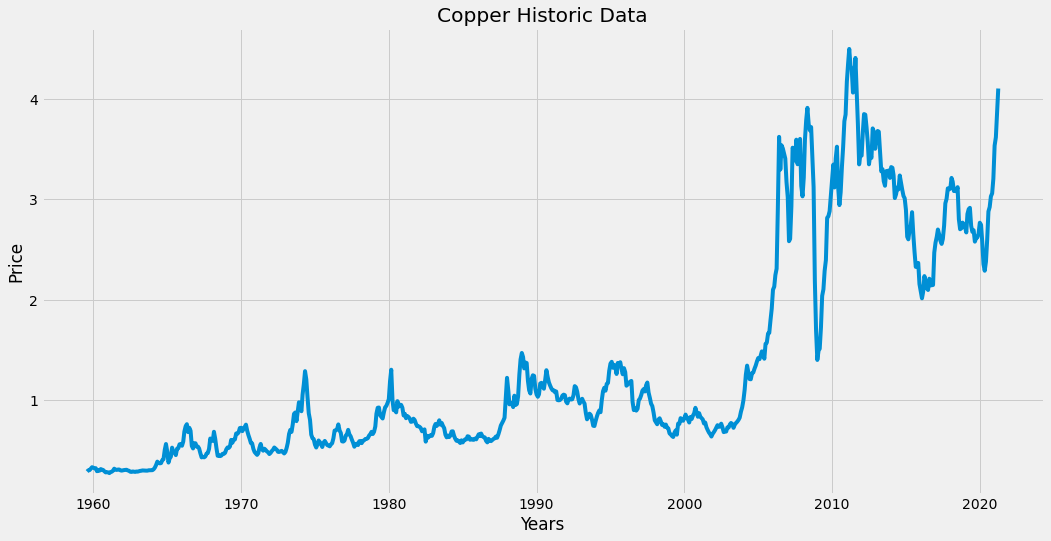

In [299]:
plt.figure(figsize=(16,8))
plt.title('Copper Historic Data')
plt.xlabel('Years')
plt.ylabel('Price')
plt.plot(df.value)
plt.show()

In [300]:
start_date = datetime(2002,1,1)
end_date = datetime(2021,3,3)
copper =df[start_date:end_date]

<ipython-input-301-689e2b453ad8>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(copper, model='additive', freq=12)
<ipython-input-301-689e2b453ad8>:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


<Figure size 432x288 with 0 Axes>

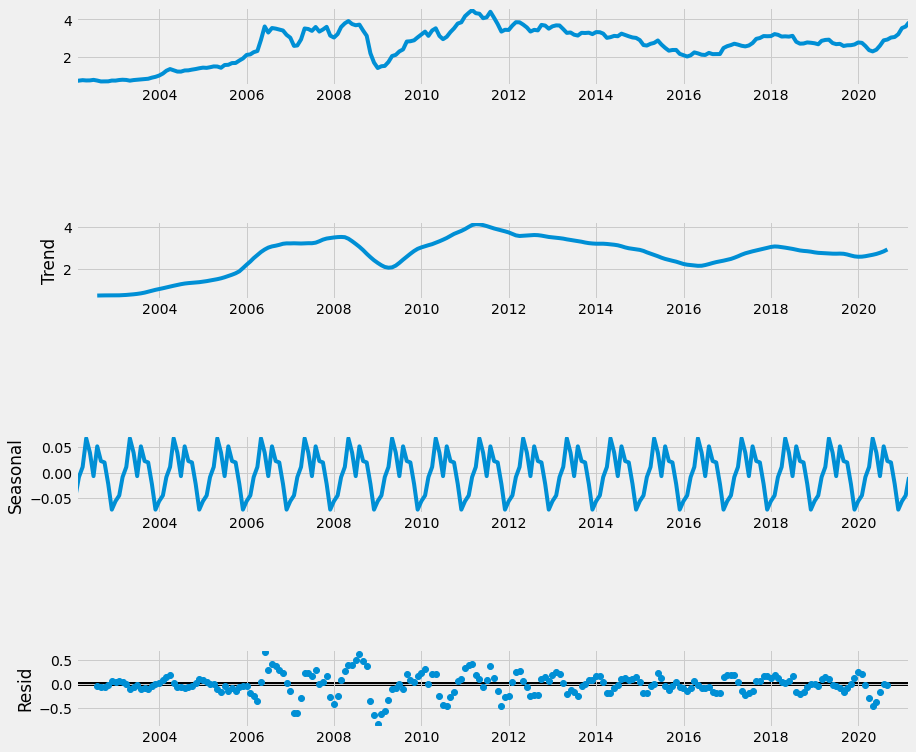

In [301]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(copper, model='additive', freq=12)

fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(15, 12)
fig.show()

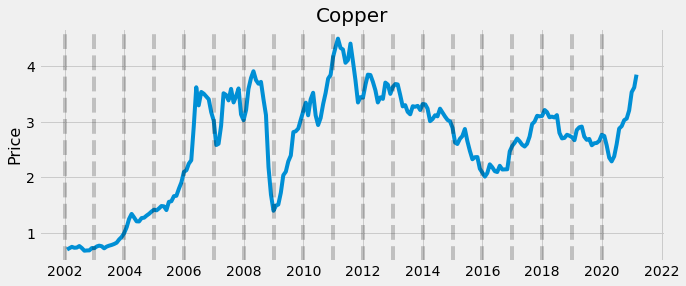

In [302]:
plt.figure(figsize=(10,4))
plt.plot(copper)
plt.title('Copper', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [303]:
first_diff = copper.diff()[1:]

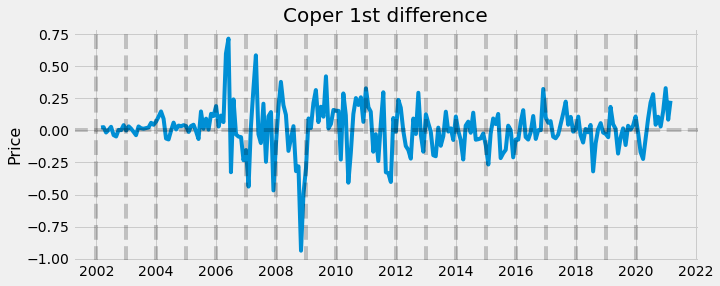

In [304]:
plt.figure(figsize=(10,4))
plt.plot(first_diff)
plt.title('Coper 1st difference', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,end_date.year):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
plt.axhline(0, color='k', linestyle='--', alpha=0.2)

/Users/timzhi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:568: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


<BarContainer object of 20 artists>

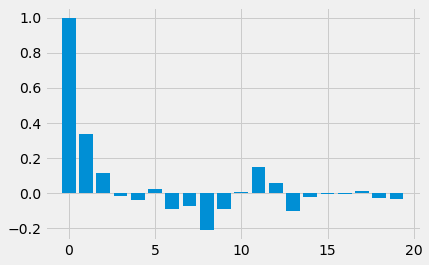

In [305]:
acf_vals = acf(first_diff)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<BarContainer object of 15 artists>

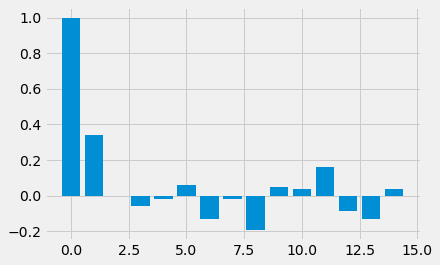

In [306]:
pacf_vals = pacf(first_diff)
num_lags = 15
plt.bar(range(num_lags), pacf_vals[:num_lags])

In [307]:
train_end = datetime(2020,1,1)
test_end = datetime(2021,3,3)

train_data = df[:train_end]
test_data = df[train_end + timedelta(days=1):test_end]

In [308]:
print(test_data)
print(train_data)

               value
date                
2020-01-31  2.745500
2020-02-29  2.576995
2020-03-31  2.354091
2020-04-30  2.288552
2020-05-31  2.379600
2020-06-30  2.596764
2020-07-31  2.878977
2020-08-31  2.922943
2020-09-30  3.029381
2020-10-31  3.059318
2020-11-30  3.206070
2020-12-31  3.535173
2021-01-31  3.618763
2021-02-28  3.849447
               value
date                
1959-07-31  0.288057
1959-08-31  0.300600
1959-09-30  0.302457
1959-10-31  0.317881
1959-11-30  0.331205
...              ...
2019-08-31  2.578359
2019-09-30  2.614400
2019-10-31  2.620261
2019-11-30  2.658175
2019-12-31  2.766838

[726 rows x 1 columns]


In [309]:
my_order = (1,1,0)
my_seasonal_order = (1,2, 3, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)

In [310]:
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/Users/timzhi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1006: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/timzhi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Model Fitting Time: 22.67328381538391


In [311]:
model_fit.mse

0.011248487150735472

In [312]:
print(model_fit.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                      value   No. Observations:                  726
Model:             SARIMAX(1, 1, 0)x(1, 2, [1, 2, 3], 12)   Log Likelihood                 523.879
Date:                                    Sun, 21 Mar 2021   AIC                          -1035.758
Time:                                            13:46:09   BIC                          -1008.443
Sample:                                        07-31-1959   HQIC                         -1025.200
                                             - 12-31-2019                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3161      0.016     20.023      0

In [313]:

#get the predictions and residuals
predictions = model_fit.forecast(len(test_data))
predictions = pd.Series(predictions, index=test_data.index)
residuals = test_data['value'] - predictions[0]

In [314]:
print(test_data.head())
print(predictions.head())
print(residuals.head())

               value
date                
2020-01-31  2.745500
2020-02-29  2.576995
2020-03-31  2.354091
2020-04-30  2.288552
2020-05-31  2.379600
date
2020-01-31    2.788037
2020-02-29    2.820842
2020-03-31    2.864553
2020-04-30    2.916795
2020-05-31    2.898655
Freq: M, dtype: float64
date
2020-01-31   -0.042537
2020-02-29   -0.211042
2020-03-31   -0.433946
2020-04-30   -0.499484
2020-05-31   -0.408437
Freq: M, Name: value, dtype: float64


Text(0, 0.5, 'Error')

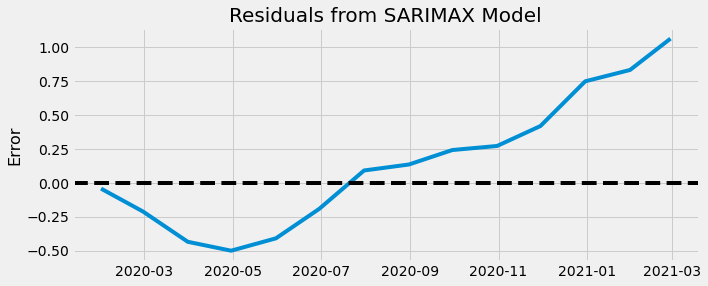

In [315]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMAX Model', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [316]:
RMSE_training=math.sqrt(model_fit.mse)

In [317]:
RMSE_training
# len(test_data)

0.10605888529838257

In [318]:
train_end = datetime(2021,3,3)
train_data = df[:train_end]
my_order = (1,1,0)
my_seasonal_order = (1,2, 3, 12)
# define model
model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
#fit the model
start = time()
model_fit = model.fit()
end = time()
print('Model Fitting Time:', end - start)

/Users/timzhi/opt/anaconda3/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Likelihood optimization failed to converge. "


Model Fitting Time: 22.656782150268555


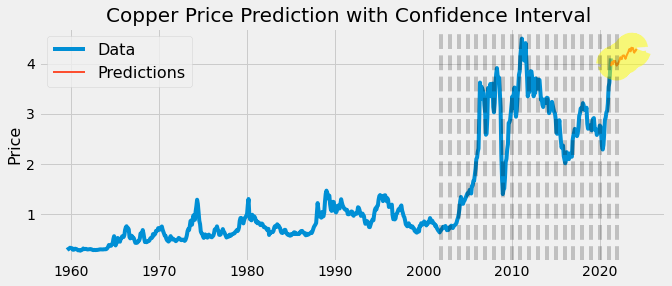

In [319]:
predictions = model_fit.forecast(36)
predictions = pd.Series(predictions)
fig=plt.figure(figsize=(10,4))

plt.plot(df)
plt.plot(predictions, linewidth="2", label ="Predictions")


plt.legend(('Data', 'Predictions'), fontsize=16)
plt.plot(predictions, linewidth="30", color="yellow", alpha=0.5)


plt.title('Copper Price Prediction with Confidence Interval ', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
fig.savefig("Copper Price Prediciton with Confidence Interval",dpi=120)

In [320]:
predictions

2021-03-31    3.947765
2021-04-30    4.019093
2021-05-31    4.033297
2021-06-30    3.987400
2021-07-31    4.058676
2021-08-31    4.031985
2021-09-30    4.054027
2021-10-31    3.992676
2021-11-30    3.960624
2021-12-31    3.998639
2022-01-31    3.995845
2022-02-28    4.032108
2022-03-31    4.074010
2022-04-30    4.127698
2022-05-31    4.111190
2022-06-30    4.089442
2022-07-31    4.157056
2022-08-31    4.161013
2022-09-30    4.163690
2022-10-31    4.132343
2022-11-30    4.094940
2022-12-31    4.140235
2023-01-31    4.177118
2023-02-28    4.205873
2023-03-31    4.236064
2023-04-30    4.286543
2023-05-31    4.292212
2023-06-30    4.244006
2023-07-31    4.317571
2023-08-31    4.290609
2023-09-30    4.313147
2023-10-31    4.251321
2023-11-30    4.217570
2023-12-31    4.258674
2024-01-31    4.258021
2024-02-29    4.295970
Freq: M, dtype: float64

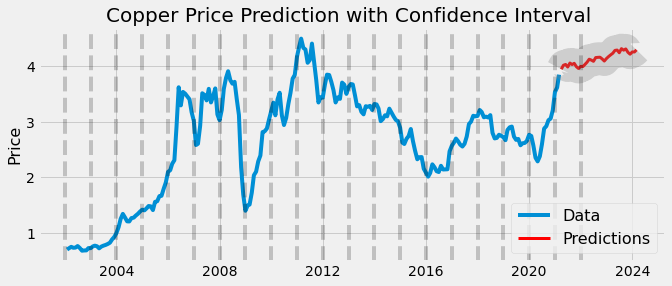

In [321]:
predictions = model_fit.forecast(36)
predictions = pd.Series(predictions)
fig=plt.figure(figsize=(10,4))

plt.plot(copper)
plt.plot(predictions, linewidth="3", label ="Predictions", color="red")


plt.legend(('Data', 'Predictions'), fontsize=16)
plt.plot(predictions, linewidth="30", color="Grey", alpha=0.3)


plt.title('Copper Price Prediction with Confidence Interval ', fontsize=20)
plt.ylabel('Price', fontsize=16)
for year in range(start_date.year,2023):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)
fig.savefig("Copper Price Prediciton with Confidence Interval",dpi=120)